In [3]:
# ==========================================
# Data Loading & Cleaning
# ==========================================
import pandas as pd
import numpy as np
import glob
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import NearestNeighbors
import os


print("Lokasi awal:", os.getcwd())

if os.getcwd().endswith("notebooks"):
    os.chdir("..")
    print("Mundur satu langkah ke root project.")

print("Lokasi sekarang:", os.getcwd())

if os.path.exists("data/raw"):
    print("✅ Folder data ditemukan!")
else:
    print("❌ Folder data MASIH tidak ditemukan. Cek lagi nama foldernya.")

# -----------------------------------------------------------------------
# 1. Load & gabungkan CSV
files = glob.glob("data/raw/*.csv")
df = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)

df.columns = (
    df.columns.str.strip().str.lower()
              .str.replace(" ", "_")
              .str.replace(r"\(.*?\)", "", regex=True)
              .str.replace("/", "_")
              .str.replace("__", "_")
              .str.replace("-", "_")
              .str.strip("_")
)

df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date','country','area'])
df.describe()

Lokasi awal: d:\College\SEM 5\Machine Learning\project-machine-learning\notebooks
Mundur satu langkah ke root project.
Lokasi sekarang: d:\College\SEM 5\Machine Learning\project-machine-learning
✅ Folder data ditemukan!


,date,ammonia,biochemical_oxygen_demand,dissolved_oxygen,orthophosphate,ph,temperature,nitrogen,nitrate,ccme_values
count,25651,25651.000000,25651.000000,25651.000000,25651.000000,25651.000000,25651.000000,25651.000000,25651.000000,25651.000000
mean,2009-03-27 06:11:48.182916864,0.180378,1.180863,8.490642,0.063232,7.951231,21.726652,0.123046,1.281441,95.993955
min,1968-12-01 00:00:00,0.000000,0.000000,0.058333,0.000000,2.100000,0.000000,0.000000,0.000000,37.659232
25%,2004-11-10 00:00:00,0.027000,0.500000,6.100000,0.007000,7.800000,18.000000,0.014000,0.042000,93.180250
50%,2009-09-01 00:00:00,0.056000,0.800000,8.200000,0.014000,8.000000,22.200000,0.020000,0.094000,100.000000
75%,2013-12-12 00:00:00,0.130000,1.366685,11.684103,0.029000,8.100000,26.400000,0.052000,0.240000,100.000000
max,2021-12-02 00:00:00,63.836364,231.108000,16.930476,35.337500,19.445000,89.000000,41.784200,150.000000,100.000000
std,NaN,1.158218,2.867754,2.813504,0.777032,0.351018,5.485493,0.593947,5.255924,6.256453


Jumlah data awal: 25651
Jumlah data setelah cleaning: 25452
Jumlah data yang dihapus: 199

=== DISTRIBUSI KUALITAS AIR ===
temp_category
Excellent    14088
Good         10937
Fair           344
Marginal        83
Name: count, dtype: int64


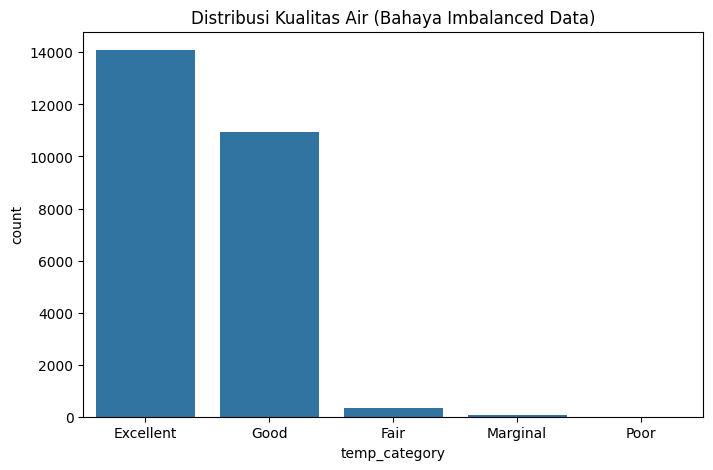

,date,ammonia,biochemical_oxygen_demand,dissolved_oxygen,orthophosphate,ph,temperature,nitrogen,nitrate,ccme_values
count,25452,25452.000000,25452.000000,25452.000000,25452.000000,25452.000000,25452.000000,25452.000000,25452.000000,25452.000000
mean,2009-03-24 23:03:21.980198144,0.122760,1.113556,8.482102,0.028767,7.952216,21.785461,0.111060,1.091613,96.267933
min,1968-12-01 00:00:00,0.000000,0.000000,0.058333,0.000000,4.100000,0.000000,0.000000,0.000000,51.076024
25%,2004-11-10 00:00:00,0.027000,0.500000,6.100000,0.007000,7.800000,18.000000,0.014000,0.041000,93.181497
50%,2009-08-07 00:00:00,0.055000,0.800000,8.200000,0.014000,8.000000,22.300000,0.020000,0.093000,100.000000
75%,2013-12-09 00:00:00,0.130000,1.300000,11.684103,0.028000,8.100000,26.400000,0.051000,0.230000,100.000000
max,2021-12-02 00:00:00,9.903110,42.100000,16.100000,0.960000,9.890000,32.100000,9.050000,50.000000,100.000000
std,NaN,0.376039,1.219039,2.818957,0.059311,0.329495,5.435426,0.451301,3.973857,5.237777


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Data Cleaning (domain-based filtering)
initial_count = len(df)  # jumlah data sebelum cleaning

df = df[(df['ph'] >= 4) & (df['ph'] <= 10)]
df = df[(df['temperature'] >= 0) & (df['temperature'] <= 40)]
df = df[df['ammonia'] <= 10]
df = df[df['biochemical_oxygen_demand'] <= 50]
df = df[df['orthophosphate'] <= 1]
df = df[df['nitrogen'] <= 10]
df = df[df['nitrate'] <= 50]

final_count = len(df)  # jumlah data setelah cleaning
deleted_count = initial_count - final_count

print(f"Jumlah data awal: {initial_count}")
print(f"Jumlah data setelah cleaning: {final_count}")
print(f"Jumlah data yang dihapus: {deleted_count}")

# Menentukan kolom numerik
num_cols = df.select_dtypes(include='number').columns.tolist()
num_cols = [c for c in num_cols if c not in ['ccme_values', 'ccme_wqi_code']]

# Cek sebaran kategori Kualitas Air
def get_category(score):
    if score >= 95: return 'Excellent'
    elif score >= 80: return 'Good'
    elif score >= 65: return 'Fair'
    elif score >= 45: return 'Marginal'
    else: return 'Poor'

# Terapkan ke data (hanya untuk ngecek)
df['temp_category'] = df['ccme_values'].apply(get_category)

print("\n=== DISTRIBUSI KUALITAS AIR ===")
print(df['temp_category'].value_counts())

# Plot Distribusi data
plt.figure(figsize=(8,5))
sns.countplot(x='temp_category', data=df, order=['Excellent', 'Good', 'Fair', 'Marginal', 'Poor'])
plt.title("Distribusi Kualitas Air (Bahaya Imbalanced Data)")
plt.show()
# Statistik deskriptif
df.describe()




In [5]:
# ==========================================
# 3. ENCODING & SPLITTING
# ==========================================
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# A. Hapus data yang tidak punya target (Jaga-jaga)
df_clean = df.dropna(subset=['temp_category'])

# B. Label Encoding (Ubah "Excellent" -> 0, "Good" -> 1, dst)
le = LabelEncoder()
df_clean['target_encoded'] = le.fit_transform(df_clean['temp_category'])

# Simpan kamus labelnya biar kita tahu artinya
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Mapping Label:", label_mapping)

# C. Tentukan Fitur (X) dan Target (y)
# Kita buang 'temp_category', 'ccme_values' (karena ini kunci jawaban), dan info lokasi/tanggal
feature_cols = ['ammonia', 'biochemical_oxygen_demand', 'dissolved_oxygen', 
                'orthophosphate', 'ph', 'temperature', 'nitrogen', 'nitrate']

X = df_clean[feature_cols]
y = df_clean['target_encoded']

# D. Split Data (80% Train, 20% Test)
# stratify=y gunanya agar perbandingan kelas di Train dan Test tetap sama
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nData Train Asli : {X_train.shape}")
print(f"Data Test Asli  : {X_test.shape}")

Mapping Label: {'Excellent': np.int64(0), 'Fair': np.int64(1), 'Good': np.int64(2), 'Marginal': np.int64(3)}

Data Train Asli : (20361, 8)
Data Test Asli  : (5091, 8)


In [10]:
# ==========================================
# 4. HANDLING IMBALANCE (SMOTE)
# ==========================================
from imblearn.over_sampling import SMOTE
import collections

# Cek dulu jumlah data sebelum di-SMOTE
print("--- SEBARAN KELAS (TRAINING SET) ---")
counter_before = collections.Counter(y_train)
print(f"Sebelum SMOTE: {dict(counter_before)}")

# Inisialisasi SMOTE
# k_neighbors=5 adalah standar. Artinya dia lihat 5 tetangga terdekat untuk bikin data baru.
smote = SMOTE(k_neighbors=5, random_state=42)

print("\nSedang menyeimbangkan data...")

try:
    # FIT RESAMPLE: Ini proses pembuatan data palsunya
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
    
    counter_after = collections.Counter(y_train_balanced)
    print(f"✅ SUKSES! Setelah SMOTE: {dict(counter_after)}")
    print(f"Total data train bertambah dari {len(y_train)} menjadi {len(y_train_balanced)}")
    
except Exception as e:
    print(f"❌ Gagal melakukan SMOTE. Error: {e}")
    # Fallback: Kalau gagal, pakai data asli
    X_train_balanced, y_train_balanced = X_train, y_train

--- SEBARAN KELAS (TRAINING SET) ---
Sebelum SMOTE: {0: 11270, 2: 8749, 1: 275, 3: 67}

Sedang menyeimbangkan data...
✅ SUKSES! Setelah SMOTE: {0: 11270, 2: 11270, 1: 11270, 3: 11270}
Total data train bertambah dari 20361 menjadi 45080


In [11]:
# ==========================================
# 5. SCALING (STANDARDISASI)
# ==========================================
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Fit (pelajari pola) hanya dari data TRAIN yang sudah di-balance
X_train_final = scaler.fit_transform(X_train_balanced)

# Transform data TEST menggunakan pola dari Train
# (Data test JANGAN di-fit, biar dia tetap jadi 'soal ujian' yang buta)
X_test_final = scaler.transform(X_test)

print("\n✅ Data siap! Dimensi akhir X_train:", X_train_final.shape)


✅ Data siap! Dimensi akhir X_train: (45080, 8)


In [14]:
# ==========================================
# 6. SAVE PROCESSED DATA (FIXED VERSION)
# ==========================================
import joblib
import os
import pandas as pd

print("\n--- MENYIMPAN DATA (FINAL) ---")

try:
    # 1. Definisikan Kolom Fitur
    feature_cols = ['ammonia', 'biochemical_oxygen_demand', 'dissolved_oxygen', 
                    'orthophosphate', 'ph', 'temperature', 'nitrogen', 'nitrate']
    
    # 2. Bungkus Data ke DataFrame
    # PENTING: Gunakan .values agar Pandas tidak bingung dengan index lama
    X_train_df = pd.DataFrame(X_train_final, columns=feature_cols)
    X_test_df = pd.DataFrame(X_test_final, columns=feature_cols)
    
    # PERBAIKAN DI SINI: Tambahkan .values
    y_train_df = pd.DataFrame(y_train_balanced.values, columns=['target'])
    y_test_df = pd.DataFrame(y_test.values, columns=['target'])

    print(f"Mengemas Data:")
    print(f" - X_train: {X_train_df.shape}")
    print(f" - y_train: {y_train_df.shape} (Harus 45080 baris)")

    # 3. Simpan ke CSV
    base_path = "data/"
    if not os.path.exists(base_path): os.makedirs(base_path)

    X_train_df.to_csv(base_path + "X_train_final.csv", index=False)
    y_train_df.to_csv(base_path + "y_train_final.csv", index=False)
    X_test_df.to_csv(base_path + "X_test_final.csv", index=False)
    y_test_df.to_csv(base_path + "y_test_final.csv", index=False)
    
    # 4. Simpan Scaler & Encoder
    joblib.dump(scaler, base_path + 'scaler.pkl')
    joblib.dump(le, base_path + 'label_encoder.pkl')
    
    print("\n✅ SUKSES TOTAL! File CSV sudah terisi.")
    print(f"Lokasi: {os.path.abspath(base_path)}")

except Exception as e:
    print(f"❌ Error saat save: {e}")


--- MENYIMPAN DATA (FINAL) ---
Mengemas Data:
 - X_train: (45080, 8)
 - y_train: (45080, 1) (Harus 45080 baris)

✅ SUKSES TOTAL! File CSV sudah terisi.
Lokasi: d:\College\SEM 5\Machine Learning\project-machine-learning\data
